In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from pyhessian import hessian
import numpy as np
import torch 
import pickle, copy
from torch.nn import MSELoss

import matplotlib.pyplot as plt
from model import Net
%matplotlib inline

In [46]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [86]:
sgd = True
suffix = "3"
model_path = "./models/model%s_%s_O100_params.pt"%("_sgd" if sgd else "",suffix)

In [60]:
torch.manual_seed(0)
generate_data = False
usepickle = True

coeffs = -1+2*np.random.rand(d, 1)
xvals = -1+2*np.random.rand(n)
fileend = ".pickle" if usepickle else ".npy"

if generate_data:
    print("Generating Data...")
    X, Y = generate_polynomial_data(coeffs, xvals)
    with open("./datasets/X%s%s" %(("pickle_" if usepickle else ""), suffix)+fileend, "wb") as f:
        if usepickle:
            pickle.dump(X, f)
        else:
            np.save(f, X)
    with open("./datasets/Y%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "wb") as f:
        if usepickle:
            pickle.dump(Y, f)
        else:
            np.save(f, Y)
    with open("./datasets/coeffs%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "wb") as f:
        if usepickle:
            pickle.dump(coeffs, f)
        else:
            np.save(f, coeffs)
    
else:
    with open("./datasets/X%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            X = pickle.load(f)
        else:
            X = np.load(f)
    with open("./datasets/Y%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            Y = pickle.load(f)
        else:
            Y = np.load(f)
    with open("./datasets/coeffs%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            coeffs = pickle.load(f)
        else:
            coeffs = np.load(f)

In [61]:
n, d = X.shape

In [70]:
usegpu = True
if torch.cuda.is_available() and usegpu:
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
#     net.to(device)

Running on GPU


In [67]:
model = Net(d, loss=MSELoss(reduction="sum"),epochs=5, categorical = False).cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [71]:
criterion = MSELoss(reduction="sum")
inputs = torch.from_numpy(X).to(device).float()
targets = torch.from_numpy(Y).to(device).float()

hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [80]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()

In [79]:
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top Hessian eigenvalue of this model is 266.6147
The top two eigenvalues of this model are: 3.1860 266.6371


In [81]:
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

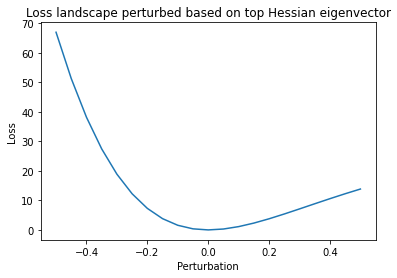

In [84]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

Text(0.5, 1.0, 'Loss landscape perturbed based on a random direction')

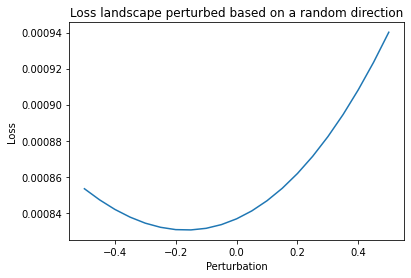

In [85]:
from pyhessian.utils import normalization

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
v = normalization(v)


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on a random direction')